# Saturated Growth model
$$ u' = u(C-u) $$
where $C=1$ and $u0=0.01$

In [1]:
import sciann as sn # https://github.com/sciann/sciann


# sciann doesn't work with the newer virsion of python
# and tensorflow. Worked with python.version=3.7.16, 
# didn't work with 3.10./3.11. Try with other's later.
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt 

import os
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

---------------------- SCIANN 0.7.0.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.11.0 
Python Version: 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)] 



In [2]:
import sys
sys.path.append('../')

In [3]:

def ode_model(u, t, C):
    return u*(C-u)

def ode_solver(t, initial_cond, params):
    initu = initial_cond
    C = params
    res = odeint(ode_model, initu, t, args=(C,))
    return res

def solveDE(initu, C, tend):
    initial_cond = [initu]
    params = [C]
    tspan = np.arange(0, tend, 0.1)
    sol = ode_solver(tspan, initial_cond, params)
    u = sol[:,0]
    plt.plot(tspan, u)
    plt.show()

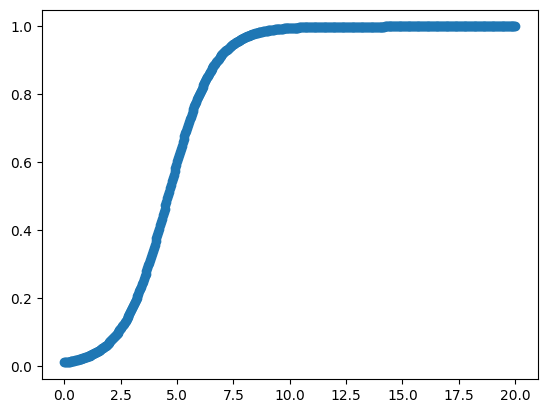

In [4]:
u0 = 0.01
C = 1
tTrain = np.linspace(0,20,500)
sol = ode_solver(tTrain, [u0], [C])
uTrain = sol[:,0]
plt.scatter(tTrain, uTrain)

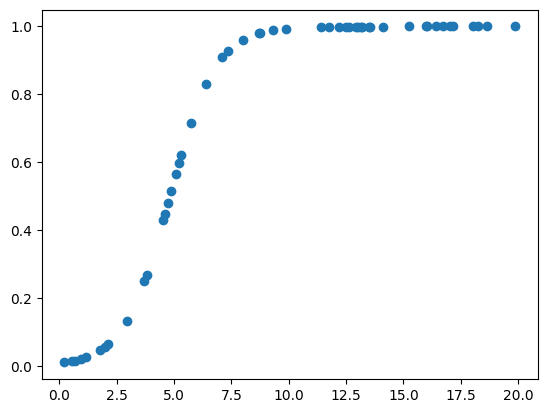

In [5]:

tTrain_sparse = np.sort(np.random.uniform(0,20,50))
sol_sparse = ode_solver(tTrain_sparse, [u0], [C])
uTrain_sparse = sol_sparse[:, 0]
plt.scatter(tTrain_sparse, uTrain_sparse)

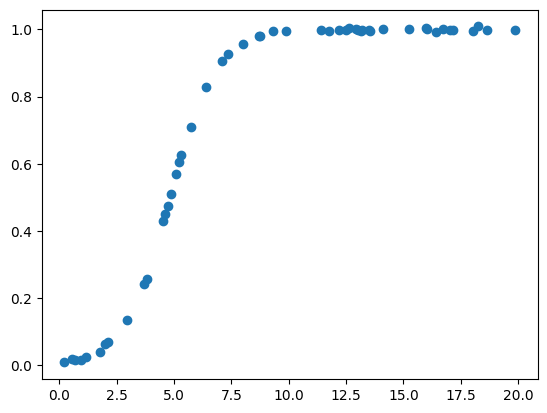

In [6]:
# Add small random noise
noise_level = 0.005
noise = np.random.normal(0, noise_level, uTrain_sparse.shape)
noisy_data = uTrain_sparse + noise

plt.scatter(tTrain_sparse, noisy_data)

In [7]:
tTrain_sparse = tTrain_sparse.reshape(-1,1)
noisy_data = noisy_data.reshape(-1,1)

# SciANN Model
Solving Inverse Problem to find model parameter "C" and the solution

In [8]:

# Model Input
t = sn.Variable("t", dtype='float64')

# NN model architecture
u = sn.Functional("u", t, 3*[5], 'tanh')


# initialize the target(learnable) parameters
C = sn.Parameter(0.5, inputs=t, name="C")

# set up grad 
u_t = sn.diff(u,t)

# Define data constraints
d1 = sn.Data(u)

# define ode constraints
c1 = sn.Tie(u_t, u*(C-u))

# set the model
model = sn.SciModel(t, [d1, c1]) # https://www.sciann.com/scimodels/#scimodel

In [9]:
# Model input
input_data = [tTrain_sparse] # tTrain, tTrain_sparse
# Constraints
data_d1 = noisy_data #u uTrain, uTrain_sparse
data_c1 = 'zeros'
# Model output 
target_data = [data_d1, data_c1]

In [10]:
# Train
history = model.train(x_true=input_data,
                      y_true=target_data,
                      epochs=500,
                      batch_size=25,
                      shuffle=True,
                      learning_rate=0.001,
                      reduce_lr_after=100,
                      stop_loss_value=1e-8,
                      verbose=1)


Total samples: 50 
Batch size: 25 
Total batches: 2 

Epoch 1/500
2/2 [==============================] - 1s 16ms/step - batch: 0.5000 - size: 25.0000 - loss: 0.3008 - u_loss: 0.2907 - sub_2_loss: 0.0100 - lr: 0.0010 - time: 1.0402
Epoch 2/500
2/2 [==============================] - 0s 16ms/step - batch: 0.5000 - size: 25.0000 - loss: 0.2886 - u_loss: 0.2787 - sub_2_loss: 0.0100 - lr: 0.0010 - time: 0.0950
Epoch 3/500
2/2 [==============================] - 0s 0s/step - batch: 0.5000 - size: 25.0000 - loss: 0.2770 - u_loss: 0.2673 - sub_2_loss: 0.0097 - lr: 0.0010 - time: 0.0942
Epoch 4/500
2/2 [==============================] - 0s 7ms/step - batch: 0.5000 - size: 25.0000 - loss: 0.2651 - u_loss: 0.2557 - sub_2_loss: 0.0095 - lr: 0.0010 - time: 0.1159
Epoch 5/500
2/2 [==============================] - 0s 16ms/step - batch: 0.5000 - size: 25.0000 - loss: 0.2540 - u_loss: 0.2447 - sub_2_loss: 0.0093 - lr: 0.0010 - time: 0.1121
Epoch 6/500
2/2 [==============================] - 0s 16ms/step

In [11]:
print("C: {}".format(C.value))

C: [0.98308469]


Visualize the loss landscape

In [12]:
from landscapeviz.utils import build_mesh
from landscapeviz.visualizer import plot_contour, plot_3d, plot_grid

In [13]:
# input_data = [tTrain_sparse] 
# target_data = [data_d1, data_c1]
zeros_array = np.zeros_like(target_data[0])
print(input_data[0].shape, target_data[0].shape, zeros_array.shape)

(50, 1) (50, 1) (50, 1)


In [14]:
seed = 20

# Build mesh
build_mesh(model, (input_data[0], [target_data[0], zeros_array]), grid_length=40, verbose=0, seed=seed)
# Note: Pass the input & target data accordingly as SciANN use tensorflow in the backend.

c:\Users\tirth\anaconda3\envs\sciann\lib\site-packages\keras\engine\training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


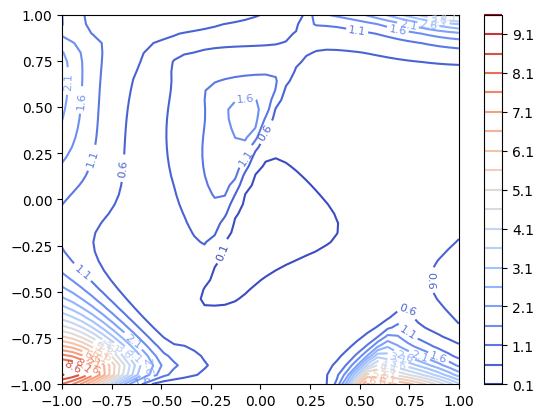

In [15]:
# Contour plot # defaul mse loss func
plot_contour(key="mse", log=False)

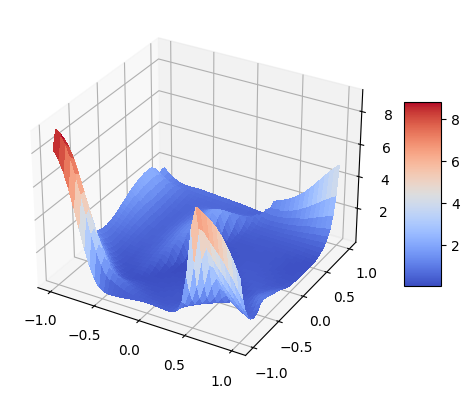

In [16]:
# Plot 3D
plot_3d(key="mse")

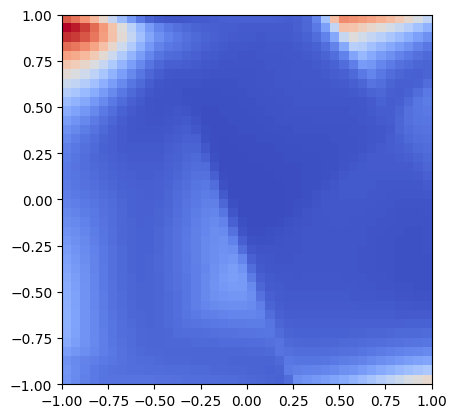

In [17]:
# Plot grid
plot_grid(key="mse")